In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import pandas as pd

# Get rid of some "wrong" errors
# check https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas for why 
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Load data
DATA_DIR = 'data' # You may change the directory

users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR))
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR))
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

In [3]:
# extract game_name and number_range from the events dataframe to match the subtasks dataframe (given the event_id)
game_name = subtasks.merge(events[['event_id', 'game_name']], on='event_id', how='left').game_name
number_range = subtasks.merge(events[['event_id', 'number_range']], on='event_id', how='left').number_range

#split the game_name into skills
skill = game_name.apply(lambda x: 'Number representation' 
                        if x in ['Subitizing', 'Conversion', 'Estimation', 'Estimation on Number Line', 'Scale: Conversion', 'Landing'] 
                        else 'Number comparison/manipulation' if x in ['Comparison', 'Secret Number', 'Distance', 'Scale: Composition', 'Order'] 
                        else 'Addition/Substraction' if x in ['Scale: Decomposition', 'Scale: Subtraction', 'Scale: Subtraction by Tens and Ones', 'Sliderule', 'Plus-minus', 'Difference', 'Completion', 'Calculator'] 
                        else 'Multiplication/Division' if x in ['Write as multiplication', 'Shelf: Jump Ahead', 'Shelf: given height', 'Shelf: random height', 'Distribution', 'Calculator: Multiplication', 'Calculator: Multiplication with ?', 'Calculator: Division', 'Jump backwards', 'Series'] 
                        else 'Other')

# concatenate skills and number range and add it to the subtasks dataframe
subtasks['skill_name'] = skill + ' ' + number_range
subtasks

,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,destination,...,subtask_finished_timestamp,target,timeoutInSeconds,timeoutInSteps,type,upperBound,divisor,orderIndependent,step,skill_name
subtask_id,,,,,,,,,,,,,,,,,,,,,
0,0,1,NaN,4,NaN,NaN,True,4,4.0,NaN,...,2022-11-02T08:39:24.930Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
1,0,1,NaN,1,NaN,NaN,True,NaN,NaN,NaN,...,2022-11-02T08:39:24.930Z,NaN,0.0,2.0,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number representation R10
2,1,1,NaN,3,NaN,NaN,True,3,NaN,ARABIC,...,2022-11-11T10:26:49.007Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
3,2,1,NaN,5,NaN,NaN,True,5,NaN,EXPLODED_BEAM,...,2022-11-18T10:34:12.191Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
4,3,1,3.0,"{'a': 2, 'b': 2.0402703}",NaN,NaN,False,"{'a': 3, 'b': 3.0}",NaN,NaN,...,2022-11-25T10:32:56.805Z,NaN,NaN,NaN,ConciseLandingTaskDescription,3.5,NaN,NaN,NaN,Number representation R10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55042,37415,998,46.0,"{'a': 47, 'b': 47.33128}",NaN,NaN,True,"{'a': 46, 'b': 46.0}",NaN,NaN,...,2021-01-06T14:14:46.133Z,NaN,NaN,NaN,ConciseLandingTaskDescription,50.0,NaN,NaN,NaN,Number representation R100
55043,37417,1000,NaN,1,NaN,NaN,False,3,3.0,NaN,...,2019-09-30T10:04:58.024Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
55044,37417,1000,NaN,2,NaN,NaN,True,NaN,NaN,NaN,...,2019-09-30T10:04:58.024Z,NaN,0.0,2.0,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number representation R10


# DKT model

In [4]:
from sklearn import feature_extraction, model_selection
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [5]:
# Useful functions for what comes next
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0).split(X, groups=groups)

def prepare_seq(df):
    # Step 1 - Enumerate skill id, each different skill has a different id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)
    # Step 2 - Cross skill id with answer to form a synthetic feature, being 2*skill_id + correct, which is 1 if subtask was correct, 0 else 
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']
    # Step 3 - Convert to a sequence per user id and shift features 1 timestep, take all skill_with_answer except last value, take all skill and correct values except first
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4 - Get max skill depth and max feature depth
    skill_depth = df['skill'].max()+1
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth, skill_codes

def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Transform sequence to Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))
    
    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=False
    )
    return dataset.repeat(), len(seq)

In [6]:
# Obtain indexes
train_index, test_index = next(create_iterator(subtasks))
# Split the data
X_train, X_test = subtasks.iloc[train_index], subtasks.iloc[test_index]

# Split train data in train and validation sets
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

In [7]:
# Specify parameters
params = {}
params['batch_size'] = 20
params['mask_value'] = -1.0

In [8]:
# Prepare the data
seq, features_depth, skill_depth, skill_codes = prepare_seq(subtasks)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)
full, full_length = prepare_data(seq, params, features_depth, skill_depth)

# Specify further params
params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

In [9]:
# Define model parameters
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

In [10]:
# Function that removes predictions on time step associated with padding, and match outputs to specific skills
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [11]:
# Define the metrics
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

In [12]:
# Model creation 
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'], name = 'masking')(inputs)
    x = tf.keras.layers.LSTM(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'], name = 'lstm_layer')(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [13]:
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 32)]        0         
                                                                 
 masking (Masking)           (None, None, 32)          0         
                                                                 
 lstm_layer (LSTM)           (None, None, 16)          3136      
                                                                 
 outputs (TimeDistributed)   (None, None, 16)          272       
                                                                 
Total params: 3,408
Trainable params: 3,408
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Model fit
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'], 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

# Model evaluation
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

Epoch 1/10
37/37 [==============================] - 6s 75ms/step - loss: 0.6379 - auc: 0.5888 - root_mean_squared_error: 0.4723 - val_loss: 0.5780 - val_auc: 0.6602 - val_root_mean_squared_error: 0.4392
Epoch 2/10
37/37 [==============================] - 2s 47ms/step - loss: 0.5197 - auc: 0.6436 - root_mean_squared_error: 0.4105 - val_loss: 0.4772 - val_auc: 0.6740 - val_root_mean_squared_error: 0.3885
Epoch 3/10
37/37 [==============================] - 2s 50ms/step - loss: 0.4672 - auc: 0.6725 - root_mean_squared_error: 0.3842 - val_loss: 0.4566 - val_auc: 0.6878 - val_root_mean_squared_error: 0.3797
Epoch 4/10
37/37 [==============================] - 2s 50ms/step - loss: 0.4564 - auc: 0.6845 - root_mean_squared_error: 0.3795 - val_loss: 0.4513 - val_auc: 0.6974 - val_root_mean_squared_error: 0.3774
Epoch 5/10
37/37 [==============================] - 2s 47ms/step - loss: 0.4530 - auc: 0.6918 - root_mean_squared_error: 0.3779 - val_loss: 0.4489 - val_auc: 0.7023 - val_root_mean_squared

In [15]:
# Getting the metrics
# Binary cross entropy, AUC, RMSE
print(metrics_dkt_small)
rmse_dkt = metrics_dkt_small[2]
auc_dkt = metrics_dkt_small[1]

[0.4425554871559143, 0.6964155435562134, 0.3733309805393219]


In [52]:
# Get index limits for the batches
indexes_limits = [0]
for i in range(len(seq_test.index.unique())//params['batch_size']) :
    indexes_limits.append(params['batch_size']*(i+1))
indexes_limits.append(test_length)

In [53]:
# Do the predictions batch-by-batch
model_predictions = []
for i in range(len(indexes_limits)-1) :
    curr_seq = seq_test[seq_test.index.unique().sort_values(ascending = True)[indexes_limits[i]:indexes_limits[i+1]]]
    curr_tf, curr_length  = prepare_data(curr_seq, params, features_depth, skill_depth)
    curr_prediction = model.predict(curr_tf, verbose = params['verbose'], steps = 1)
    model_predictions.append(curr_prediction)

1/1 [==============================] - 0s 27ms/step


In [54]:
len(X_test["user_id"].unique())

186

In [59]:
# Define some useful functions for the apply operations that come next
def new_user_id(series, unique_ids) :
    for i in range(len(unique_ids)) :
        if(unique_ids[i] == series["user_id"]) :
            return i
        
def fetch_prediction(series, predictions) :
    timepoint_number = series["timepoint"]-1
    if(timepoint_number == -1) :
        return -999
    else : 
        batch_number = series["new_user_id"]//params["batch_size"]
        number_withinBatch = series["new_user_id"]%params["batch_size"]
        skill_code = series["skill_code"]
        return predictions[batch_number][number_withinBatch, timepoint_number, skill_code]

In [77]:
# Get a dataframe of interest
# The original features we are interested in are : user_id, skill_name, correct
proba_df = X_test[["user_id", "skill_name", "correct"]]

# Add a column to have a user_id that starts from 0 and doesn't skip any number, this will be removed later
unique_ids = proba_df["user_id"].unique()
proba_df["new_user_id"] = proba_df.apply(lambda x : new_user_id(x, unique_ids), axis = 1)

# Generate column with timepoint proba_df 
proba_df["index_copy"] = proba_df.index
start_idxs = proba_df.groupby(by = "new_user_id").min()["index_copy"].values
proba_df["timepoint"] = proba_df.apply(lambda x : x["index_copy"] - start_idxs[x["new_user_id"]], axis = 1)
proba_df

# Fetch the skill codes
skill_codes_dict = {}
for i in range(len(skill_codes)) :
        skill_codes_dict[skill_codes[i]] = i
proba_df["skill_code"] = proba_df.apply(lambda x : skill_codes_dict[x["skill_name"]], axis = 1)

In [78]:
# Fetch the prediction and add to dataframe
proba_df["correct_predictions"] = proba_df.apply(lambda x : fetch_prediction(x, model_predictions), axis = 1)

# Get rid of useless columns, rename the "correct" column to "y_true" and convert it to 0s and 1s
proba_df.drop(["new_user_id", "index_copy", "timepoint", "skill_code", "correct"], axis = 1, inplace = True)

# Get rid of the rows representing the first attempt, as there is no prediction on those
proba_df = proba_df[proba_df["correct_predictions"]!=-999]

# Add the attempt number 
proba_df["attempt"] = proba_df.groupby(by = "user_id").cumcount().apply(lambda x : x+1)
proba_df

,user_id,skill_name,correct_predictions,attempt
subtask_id,,,,
84,3,Number representation R10,0.559468,1
85,3,Number comparison/manipulation R10,0.544082,2
86,3,Number comparison/manipulation R10,0.557322,3
87,3,Number comparison/manipulation R20,0.750146,4
88,3,Number comparison/manipulation R20,0.816271,5
...,...,...,...,...
55041,998,Number representation R100,0.640100,28
55042,998,Number representation R100,0.671696,29
55044,1000,Number representation R10,0.559468,1


# Fit the exponential function

In [79]:
def exp_model(x, a, b, lambda_):
    return a - b*np.exp(-lambda_*x)

def exp_fit(x):
    param_pred, _ = scipy.optimize.curve_fit(lambda t,a,b,lambda_: a-b*np.exp(-lambda_*t),  x.attempt,  x.correct_predictions, bounds=([0,-1,0], [1, 1, np.inf]))
    a, b, lambda_ = param_pred
    return pd.Series([a, b, lambda_], index=['a', 'b', 'lambda_'])

In [80]:
# Define set of skills
skills = subtasks['skill_name'].unique()

# Make prediction dataset
proba_dataset = {}
proba_test = {}
for skill in skills:
    proba_dataset[skill] = proba_df[proba_df["skill_name"] == skill]
    proba_test[skill] = proba_df[proba_df["skill_name"] == skill]
    
    # Add the attempt number
    proba_dataset[skill]['attempt'] = proba_dataset[skill].groupby(by = "user_id").cumcount()
    proba_test[skill]['attempt'] = proba_test[skill].groupby(by = "user_id").cumcount()

proba_dataset['Number representation R10']

,user_id,skill_name,correct_predictions,attempt
subtask_id,,,,
84,3,Number representation R10,0.559468,0
119,6,Number representation R10,0.559468,0
120,6,Number representation R10,0.600974,1
278,9,Number representation R10,0.559468,0
280,9,Number representation R10,0.593404,1
...,...,...,...,...
55019,998,Number representation R10,0.647573,4
55020,998,Number representation R10,0.653904,5
55044,1000,Number representation R10,0.559468,0


In [81]:
# Compute the parameters for the exponential fit for each student
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    students_param = {}
    for skill in skills:
        students_param[skill] = proba_dataset[skill].groupby('user_id').apply(lambda x: exp_fit(x))
        students_param[skill]['number_attempts'] = proba_dataset[skill].groupby('user_id').size()

Number representation R10


,a,b,lambda_,number_attempts
count,1.830000e+02,183.000000,183.000000,183.000000
mean,6.449165e-01,0.070453,2.925789,4.453552
std,1.589202e-01,0.163804,5.436744,4.107990
min,5.343065e-14,-0.617142,0.004382,1.000000
25%,5.970895e-01,0.026324,0.368470,2.000000
50%,6.298937e-01,0.045484,1.000000,3.000000
75%,6.753791e-01,0.100539,2.026818,5.000000
max,1.000000e+00,0.458555,21.650846,35.000000


Number comparison/manipulation R20


,a,b,lambda_,number_attempts
count,105.000000,105.000000,105.000000,105.000000
mean,0.872490,0.025814,2.240122,12.723810
std,0.154063,0.168317,5.458488,14.012011
min,0.003892,-0.894809,0.000849,1.000000
25%,0.891519,0.019741,0.286575,3.000000
50%,0.901478,0.041993,0.673648,7.000000
75%,0.909922,0.097353,1.135727,18.000000
max,1.000000,0.317914,38.196399,60.000000


Number representation R20


,a,b,lambda_,number_attempts
count,1.410000e+02,141.000000,141.000000,141.000000
mean,7.466909e-01,0.081945,3.007469,8.000000
std,1.991998e-01,0.207116,6.319801,10.255312
min,2.014083e-11,-0.748367,0.003177,1.000000
25%,6.569442e-01,-0.016944,0.081005,2.000000
50%,7.569408e-01,0.076237,0.690044,4.000000
75%,8.219177e-01,0.208793,1.359427,10.000000
max,1.000000e+00,0.428466,26.154390,71.000000


Number comparison/manipulation R10


,a,b,lambda_,number_attempts
count,66.000000,66.000000,66.000000,66.000000
mean,0.744189,0.094144,1.739180,4.439394
std,0.139908,0.139019,2.324631,5.575023
min,0.503363,-0.313973,0.047100,1.000000
25%,0.618215,0.019073,0.515450,2.000000
50%,0.747321,0.099910,1.100403,2.000000
75%,0.866565,0.149764,2.050249,5.750000
max,1.000000,0.471628,16.457869,30.000000


Addition/Substraction R10


,a,b,lambda_,number_attempts
count,57.000000,57.000000,57.000000,57.000000
mean,0.714229,-0.017572,4.189420,2.649123
std,0.134241,0.149765,7.861841,2.601450
min,0.550465,-0.276263,0.001587,1.000000
25%,0.580856,-0.156909,1.000000,1.000000
50%,0.719209,0.003900,1.000000,2.000000
75%,0.805164,0.047962,2.536290,3.000000
max,1.000000,0.357027,40.740702,14.000000


Number representation R100


,a,b,lambda_,number_attempts
count,98.000000,98.000000,98.000000,98.000000
mean,0.784913,0.164087,0.512356,13.010204
std,0.147603,0.151653,1.579955,13.951680
min,0.045536,-0.636109,0.007960,1.000000
25%,0.737087,0.088716,0.079047,5.000000
50%,0.753819,0.151320,0.179476,8.000000
75%,0.869614,0.248457,0.312869,17.000000
max,1.000000,0.443020,15.060857,81.000000


Number comparison/manipulation R100


,a,b,lambda_,number_attempts
count,81.000000,81.000000,81.000000,81.000000
mean,0.899169,0.058619,1.549870,13.222222
std,0.093960,0.106513,4.008201,13.733172
min,0.602575,-0.249855,0.031367,1.000000
25%,0.903417,0.033725,0.262575,3.000000
50%,0.911591,0.056096,0.523045,8.000000
75%,0.922432,0.105023,1.000000,18.000000
max,1.000000,0.498996,22.079675,60.000000


Addition/Substraction R100


,a,b,lambda_,number_attempts
count,3.300000e+01,33.000000,33.000000,33.000000
mean,5.824385e-01,-0.108182,3.763534,2.939394
std,2.050268e-01,0.216843,6.302083,2.597347
min,9.604878e-12,-0.764566,0.005565,1.000000
25%,5.741429e-01,-0.133154,0.894866,1.000000
50%,6.189408e-01,-0.079111,1.000000,2.000000
75%,6.514531e-01,-0.010435,3.133158,4.000000
max,9.790535e-01,0.366846,23.395258,13.000000


Number representation R1000


,a,b,lambda_,number_attempts
count,55.000000,55.000000,55.000000,55.000000
mean,0.823042,0.144209,0.619151,23.709091
std,0.093231,0.099620,2.323445,18.866660
min,0.545188,-0.090376,0.012588,1.000000
25%,0.792356,0.090465,0.071474,10.000000
50%,0.803690,0.128320,0.152717,19.000000
75%,0.826940,0.183204,0.248055,34.000000
max,1.000000,0.357898,17.076337,73.000000


Multiplication/Division R20


,a,b,lambda_,number_attempts
count,3.000000e+01,30.000000,30.000000,30.000000
mean,4.827827e-01,-0.284270,1.884309,4.966667
std,3.794939e-01,0.398539,4.286789,3.846031
min,1.321977e-14,-0.812120,0.001719,1.000000
25%,2.239687e-06,-0.779522,0.008545,2.250000
50%,7.009865e-01,-0.095312,0.590255,3.000000
75%,7.940363e-01,0.030877,1.214274,7.750000
max,1.000000e+00,0.268159,20.461543,17.000000


Number comparison/manipulation R1000


,a,b,lambda_,number_attempts
count,50.000000,50.000000,50.000000,50.000000
mean,0.908817,0.007561,0.441693,46.400000
std,0.102250,0.096565,0.476934,40.793157
min,0.521997,-0.282434,0.018873,1.000000
25%,0.937314,0.015195,0.158011,11.000000
50%,0.939531,0.021764,0.302033,39.000000
75%,0.940808,0.031807,0.485329,66.000000
max,1.000000,0.314784,2.846138,153.000000


Addition/Substraction R1000


,a,b,lambda_,number_attempts
count,24.000000,24.000000,24.000000,24.000000
mean,0.615118,-0.067731,2.689938,4.916667
std,0.176849,0.177682,5.026789,8.010410
min,0.000018,-0.647756,0.010587,1.000000
25%,0.569406,-0.120239,0.266278,1.000000
50%,0.613834,-0.091142,1.000000,3.000000
75%,0.637528,-0.017693,1.530315,4.250000
max,1.000000,0.378516,17.952847,39.000000


Multiplication/Division R100


,a,b,lambda_,number_attempts
count,2.200000e+01,22.000000,22.000000,22.000000
mean,6.934373e-01,-0.160746,3.731756,4.272727
std,2.716105e-01,0.291024,5.491880,4.049478
min,3.091538e-10,-0.881971,0.001720,1.000000
25%,6.097518e-01,-0.243032,0.172588,2.000000
50%,8.216471e-01,-0.006267,1.000000,3.000000
75%,8.774940e-01,0.003442,3.646120,5.000000
max,9.510166e-01,0.322412,16.696610,19.000000


Addition/Substraction R20


,a,b,lambda_,number_attempts
count,69.000000,69.000000,69.000000,69.000000
mean,0.668812,-0.003206,4.075233,4.000000
std,0.111728,0.110401,6.426209,3.850134
min,0.258414,-0.446911,0.001784,1.000000
25%,0.634960,-0.015869,1.000000,2.000000
50%,0.684831,0.003078,1.604199,2.000000
75%,0.699724,0.028729,2.612600,5.000000
max,1.000000,0.312822,25.987513,19.000000


Multiplication/Division R1000


,a,b,lambda_,number_attempts
count,1.100000e+01,11.000000,11.000000,11.000000
mean,7.197332e-01,-0.064527,2.453037,4.727273
std,2.503917e-01,0.260947,5.161563,4.027180
min,4.537995e-11,-0.816870,0.007823,1.000000
25%,7.889927e-01,0.002881,0.428775,3.000000
50%,7.961475e-01,0.018627,0.717545,3.000000
75%,8.037507e-01,0.030037,1.436388,4.500000
max,9.246338e-01,0.128017,17.794225,16.000000


Multiplication/Division R10


,a,b,lambda_,number_attempts
count,10.000000,10.000000,10.000000,10.000000
mean,0.878101,0.073745,2.268447,5.800000
std,0.052819,0.100752,4.989851,3.645393
min,0.828892,-0.018369,0.018760,3.000000
25%,0.853792,0.010929,0.393507,3.000000
50%,0.858264,0.025871,0.614701,4.500000
75%,0.864760,0.127052,1.321285,7.000000
max,1.000000,0.297142,16.407159,14.000000


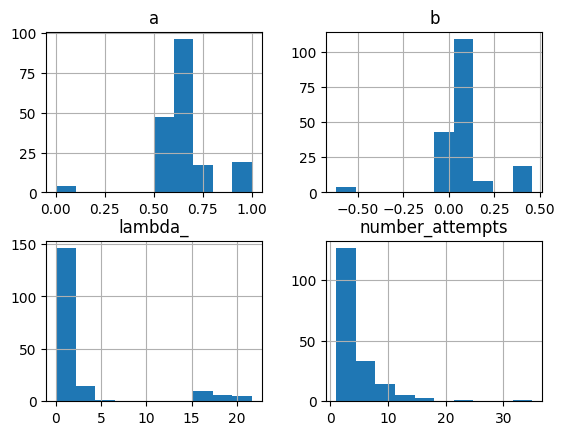

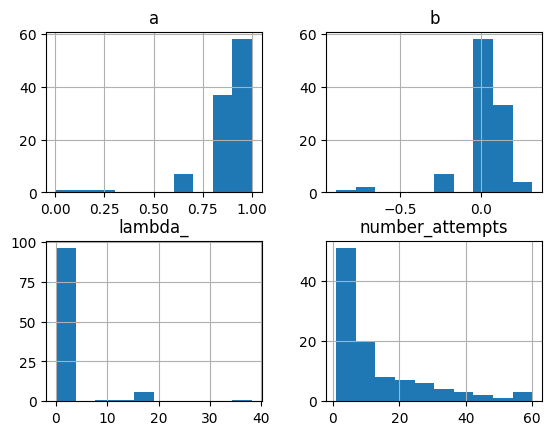

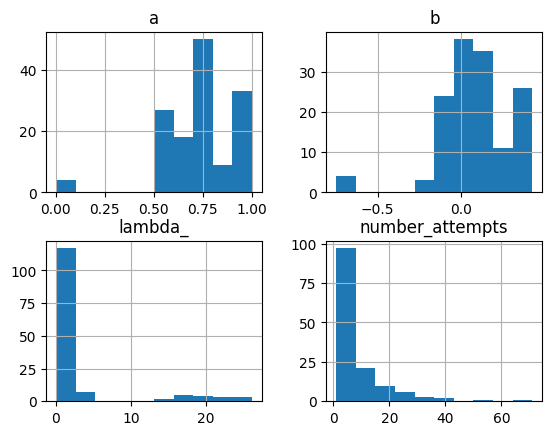

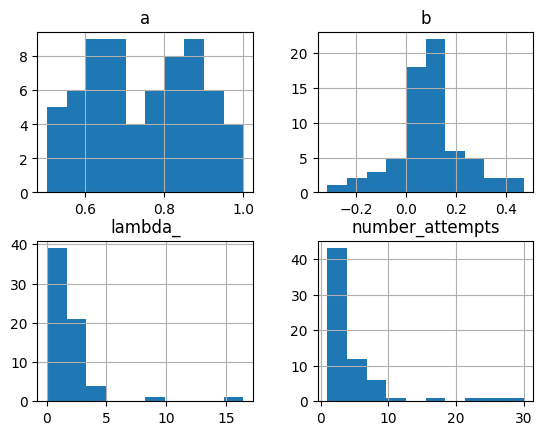

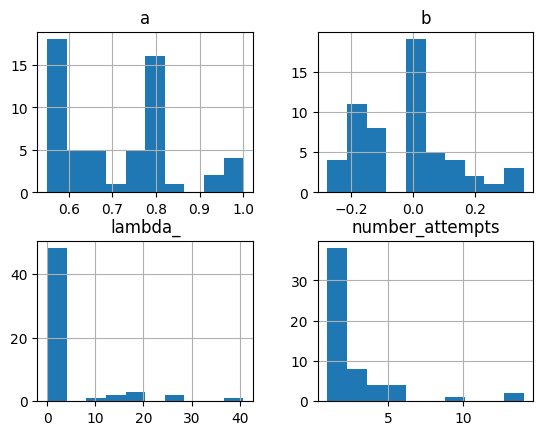

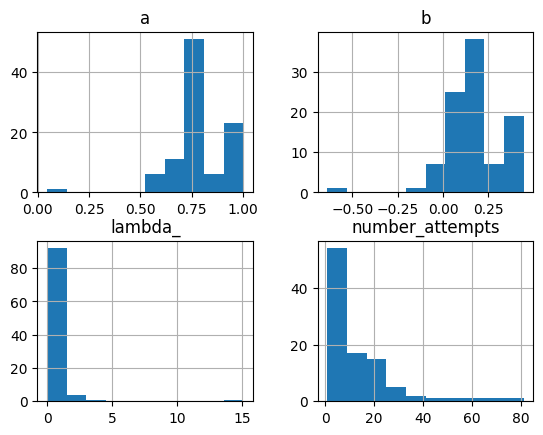

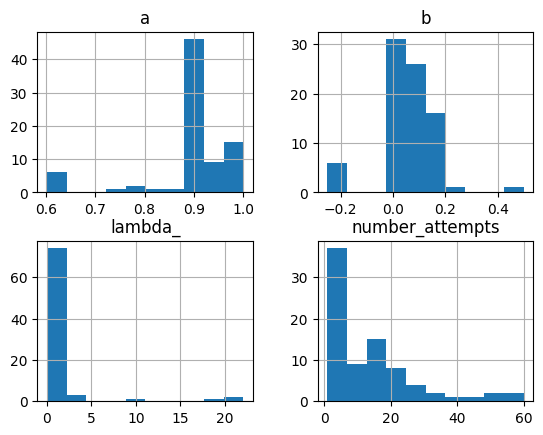

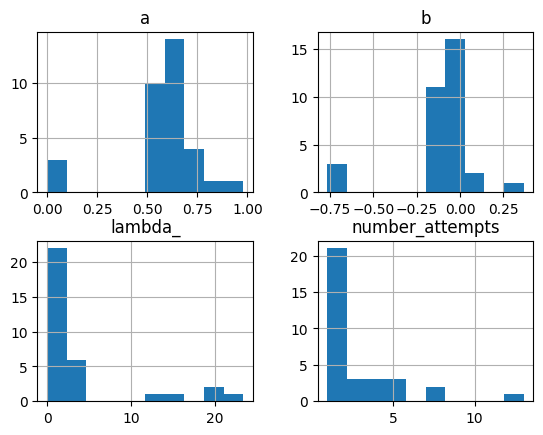

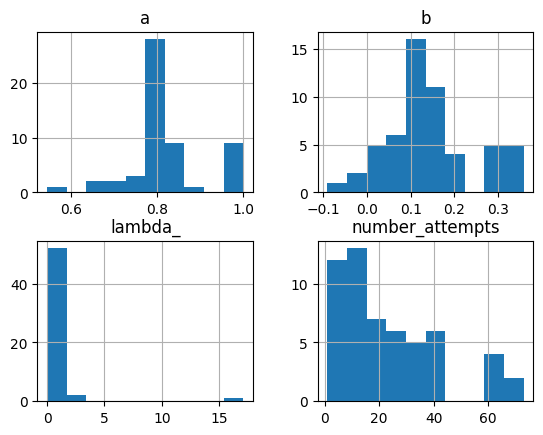

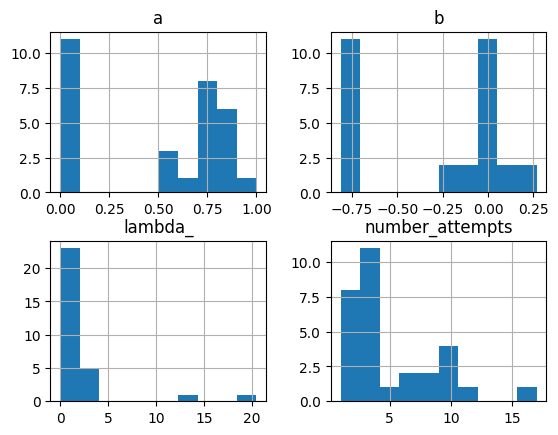

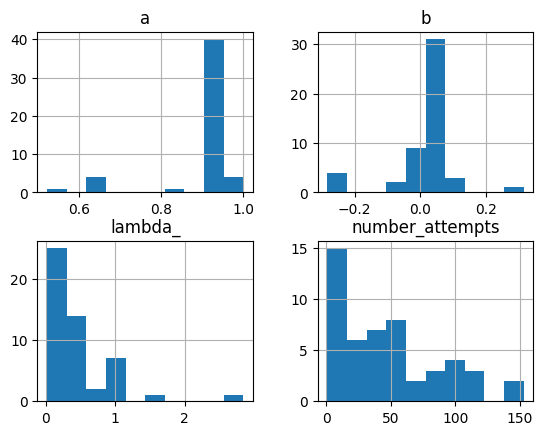

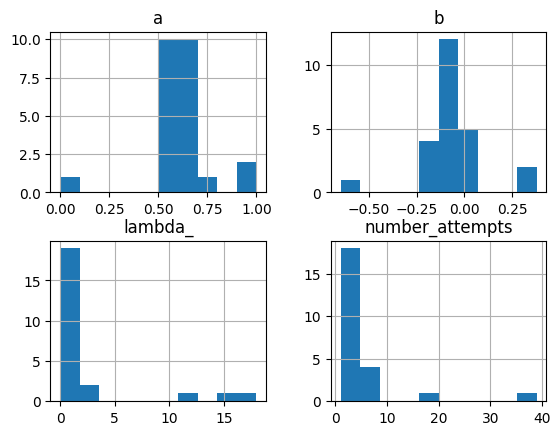

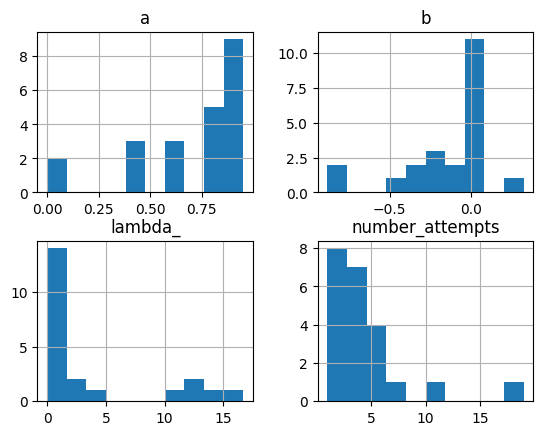

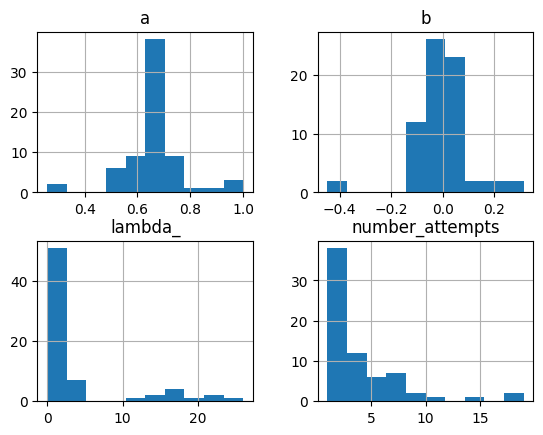

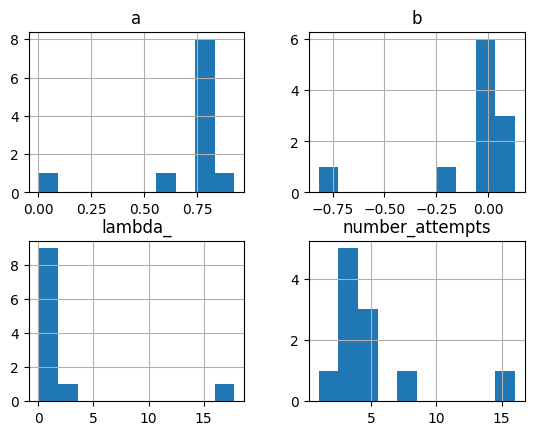

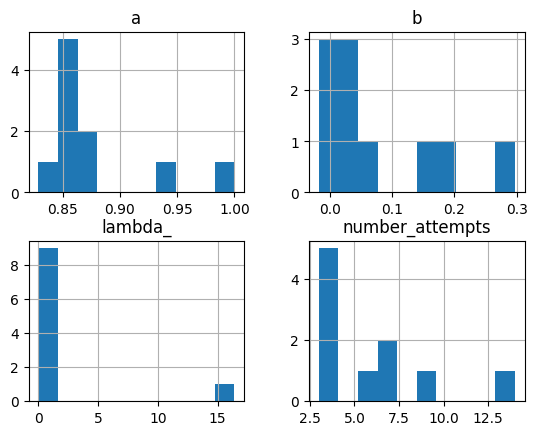

In [82]:
# Histogram and descriptive statistics of the parameters for each skill
for skill in skills :
    print(skill)
    pd.DataFrame(students_param[skill]).hist()
    display(pd.DataFrame(students_param[skill]).describe())

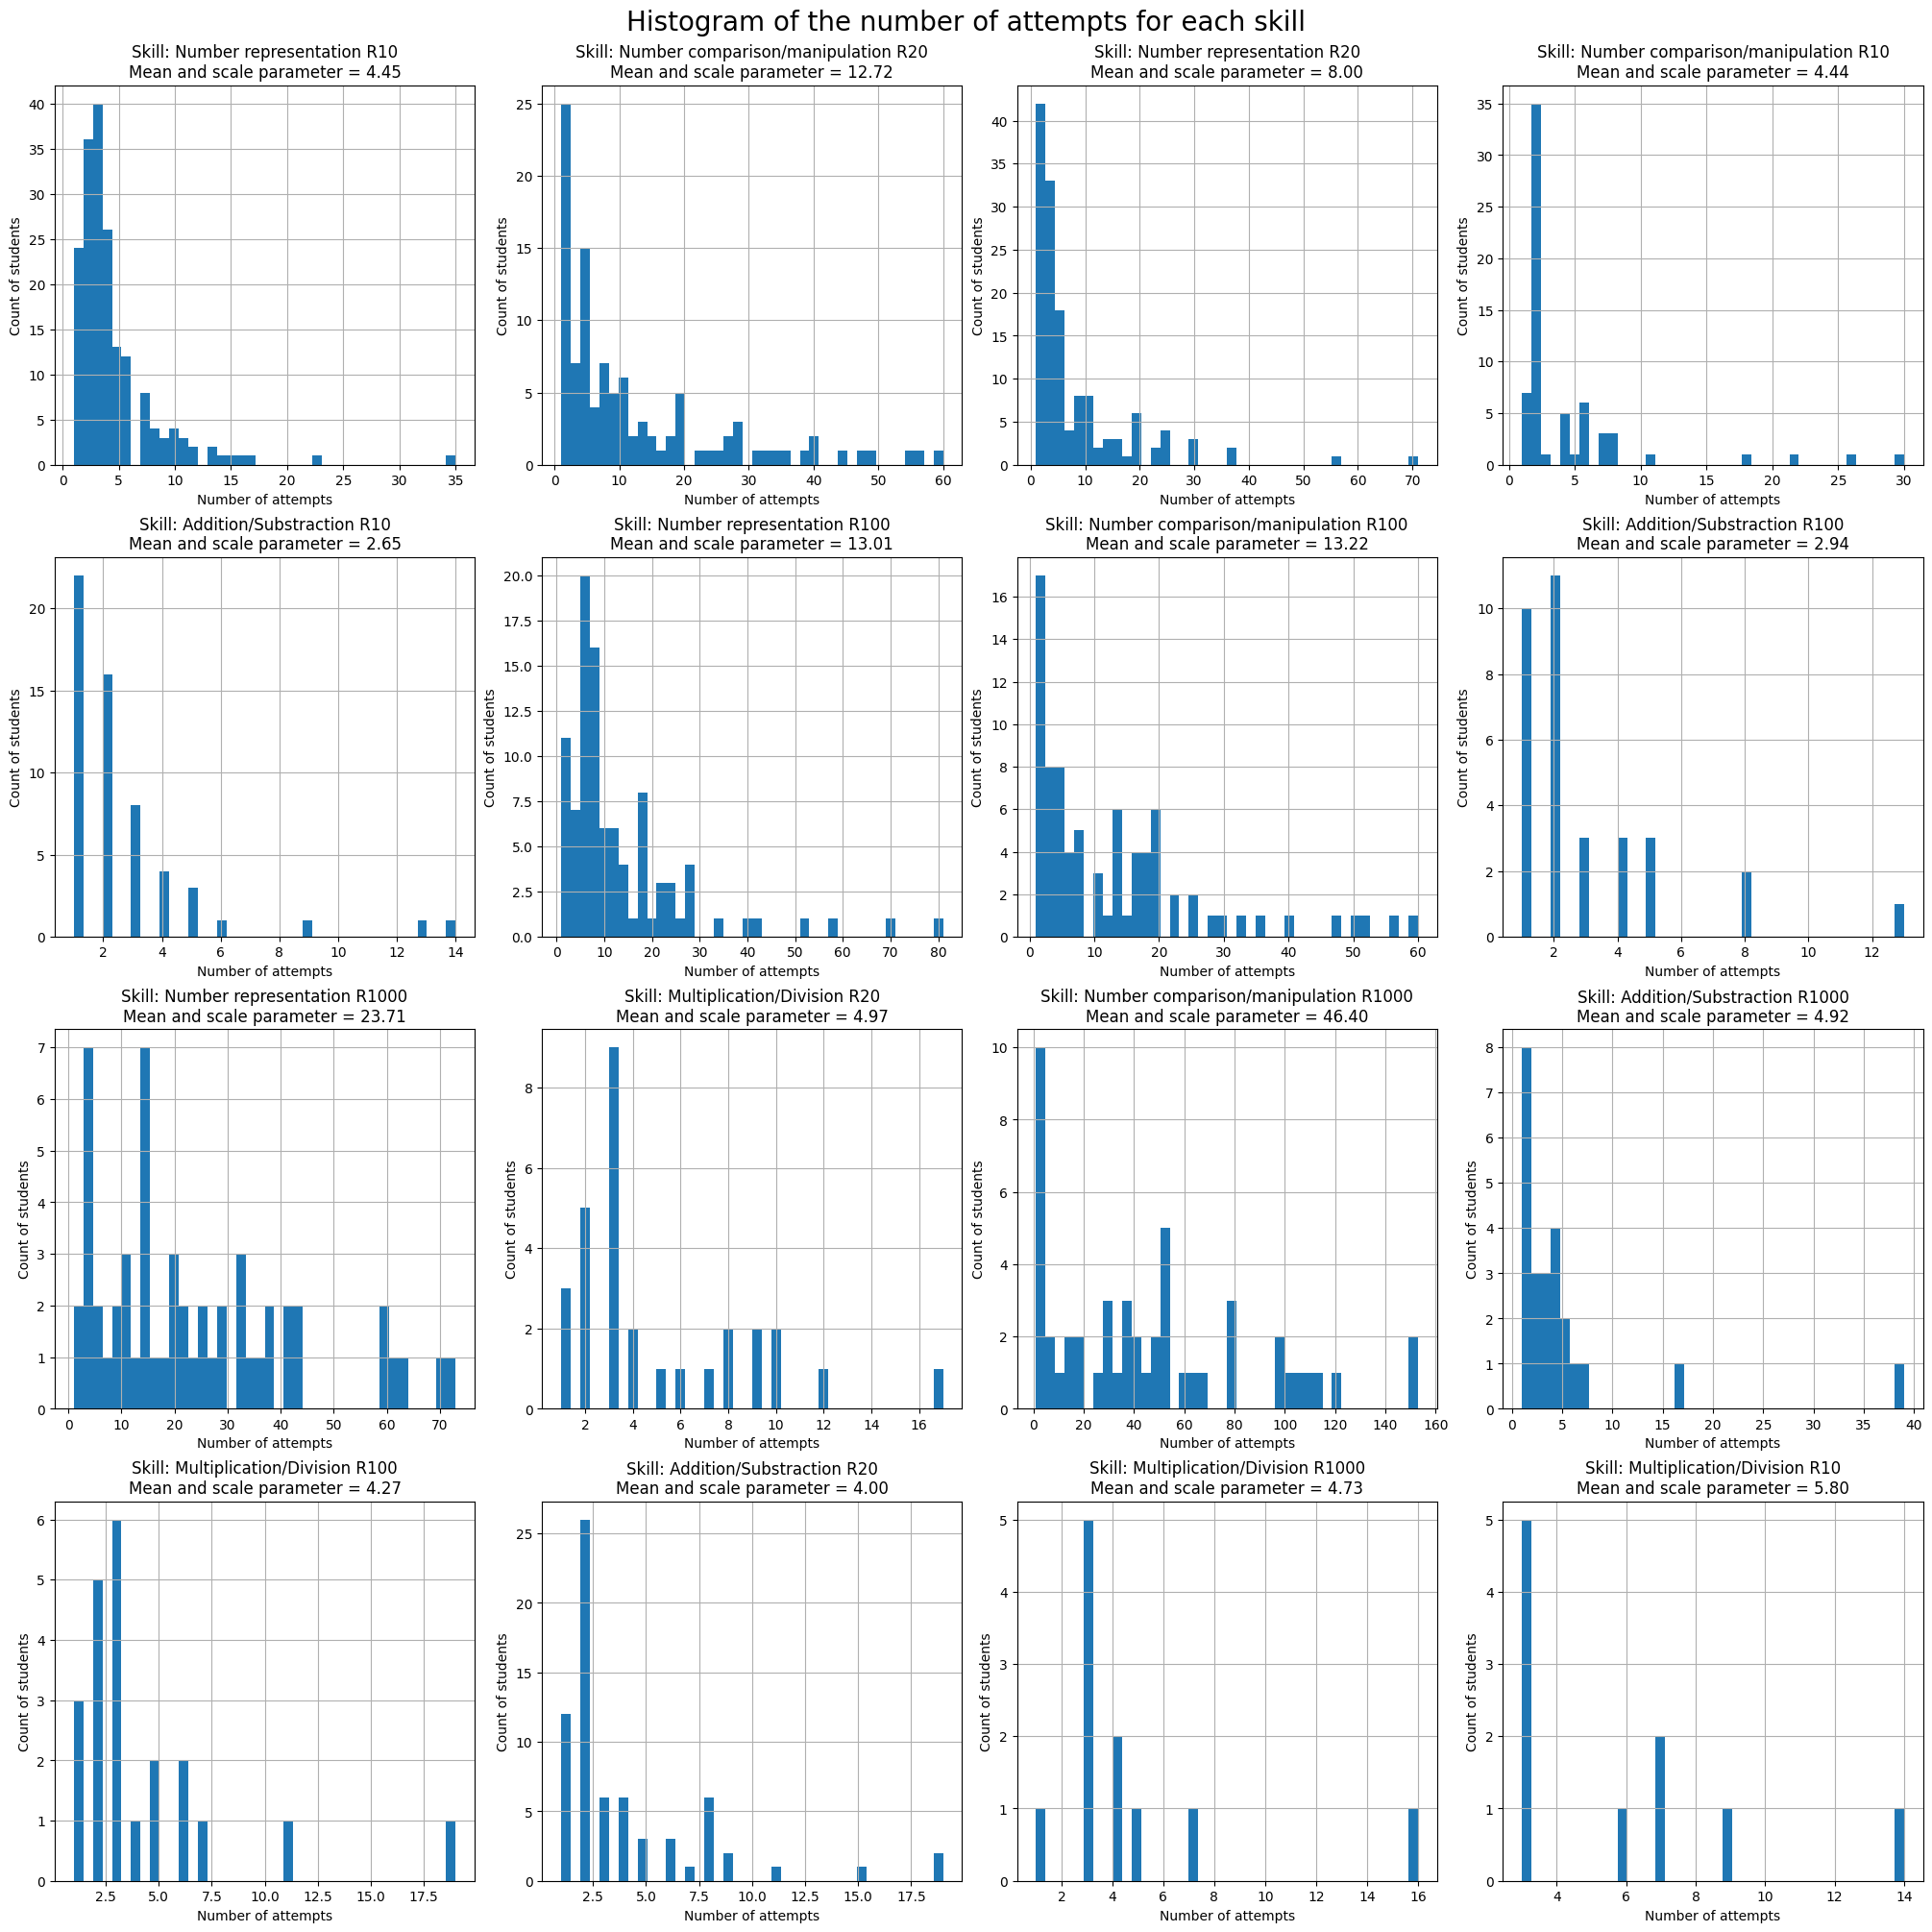

In [83]:
# Plot the histogram of the number of attempts
scale_param = {}
fig, ax = plt.subplots(4, 4, figsize=(4*5, 4*5), constrained_layout=True)
for skill, axe in zip(skills, ax.flatten()):
    scale_param[skill] = students_param[skill].number_attempts.mean()
    students_param[skill].number_attempts.hist(bins=40, ax=axe)
    axe.set_title('Skill: {}\nMean and scale parameter = {:.2f}'.format(skill, scale_param[skill]))
    axe.set_xlabel('Number of attempts')
    axe.set_ylabel('Count of students')
plt.suptitle('Histogram of the number of attempts for each skill', fontsize=20)
plt.show()

For the skill Number representation R10 there is 32 students with more than 6 attempts which corresponds to 17.49 % of the students


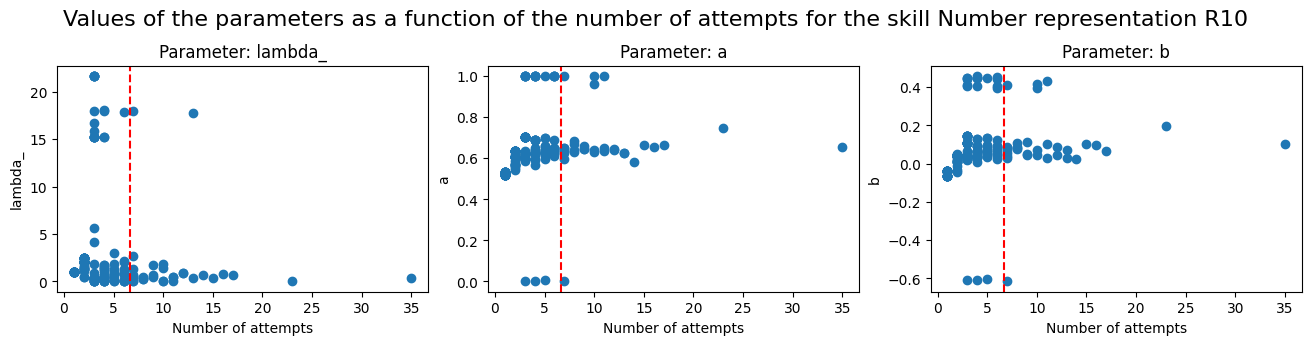

For the skill Number comparison/manipulation R20 there is 25 students with more than 19 attempts which corresponds to 23.81 % of the students


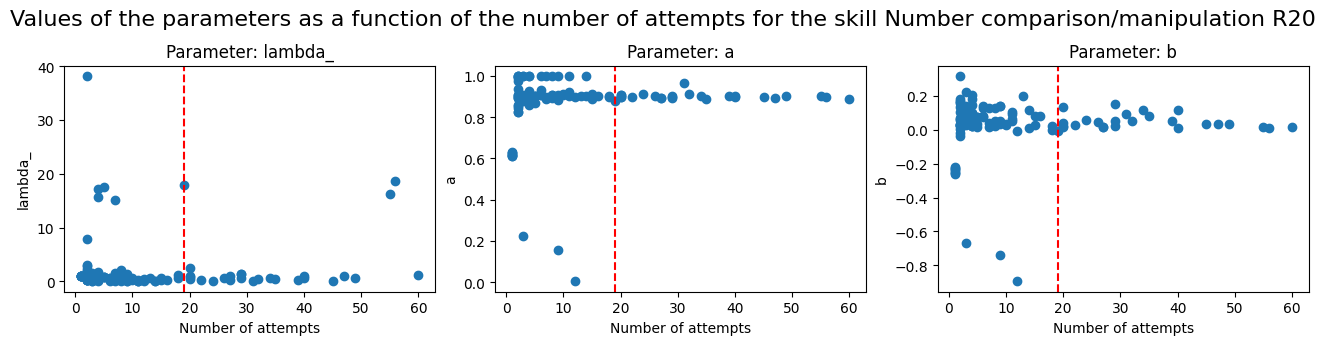

For the skill Number representation R20 there is 26 students with more than 12 attempts which corresponds to 18.44 % of the students


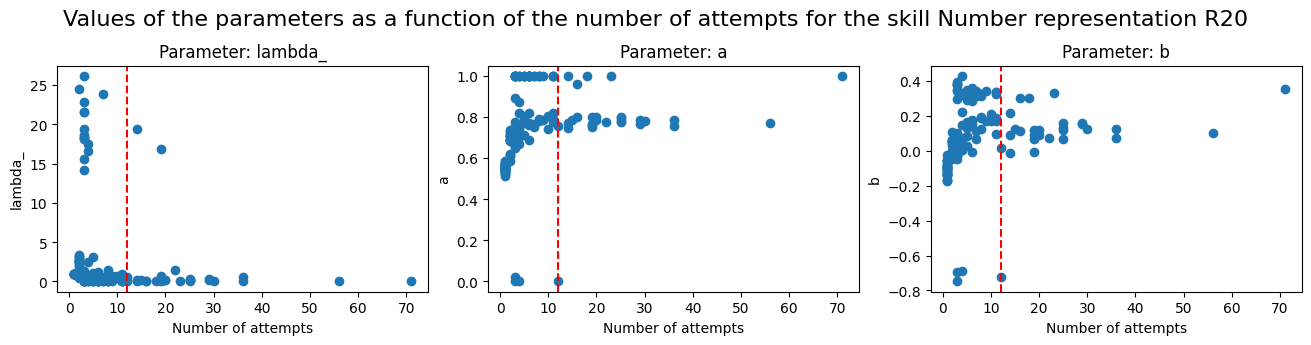

For the skill Number comparison/manipulation R10 there is 11 students with more than 6 attempts which corresponds to 16.67 % of the students


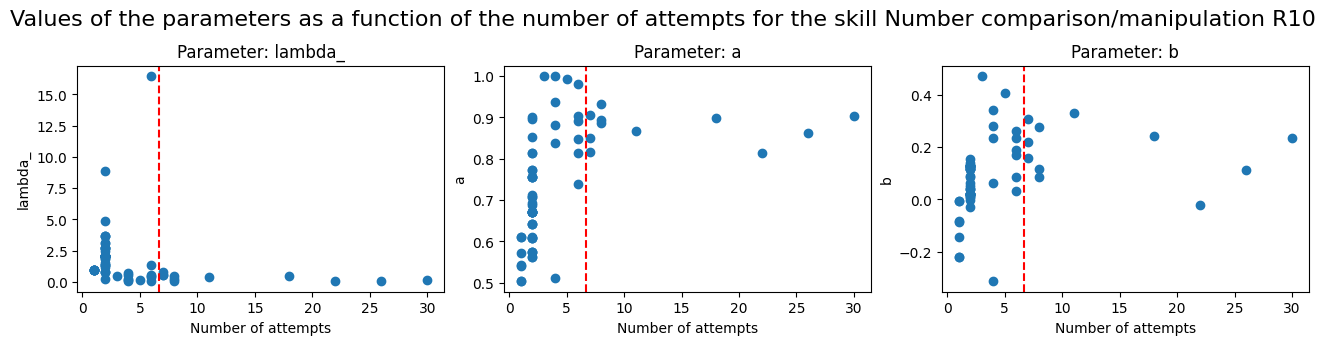

For the skill Addition/Substraction R10 there is 11 students with more than 3 attempts which corresponds to 19.3 % of the students


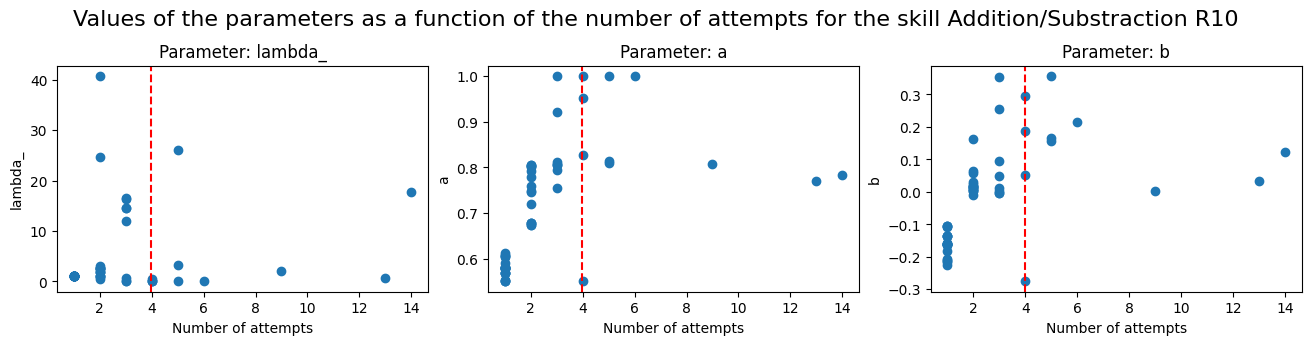

For the skill Number representation R100 there is 18 students with more than 19 attempts which corresponds to 18.37 % of the students


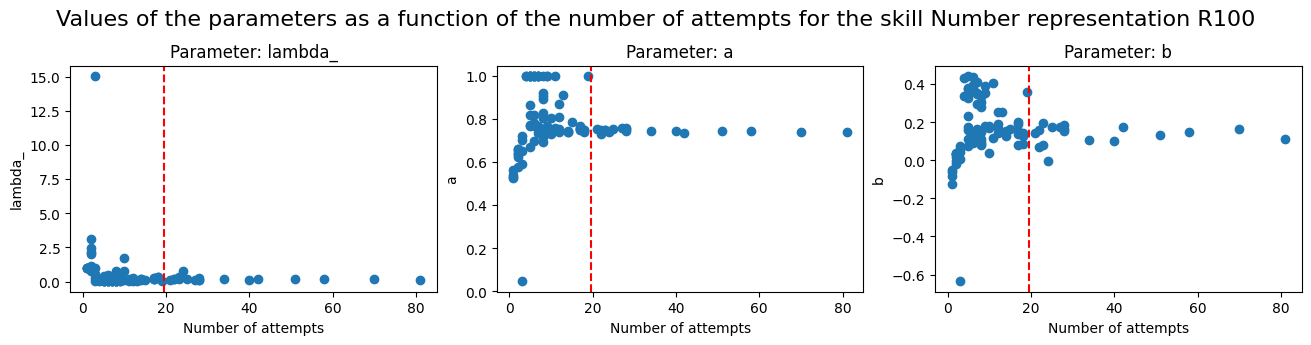

For the skill Number comparison/manipulation R100 there is 15 students with more than 19 attempts which corresponds to 18.52 % of the students


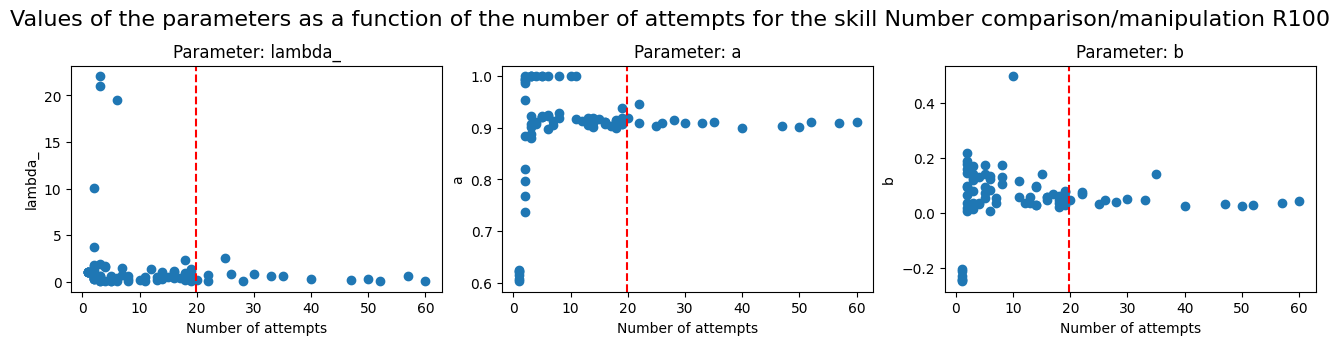

For the skill Addition/Substraction R100 there is 6 students with more than 4 attempts which corresponds to 18.18 % of the students


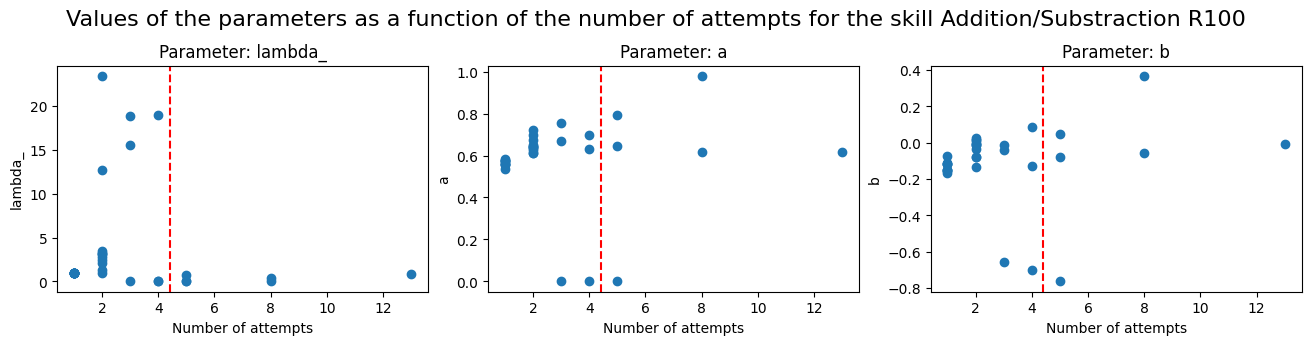

For the skill Number representation R1000 there is 13 students with more than 35 attempts which corresponds to 23.64 % of the students


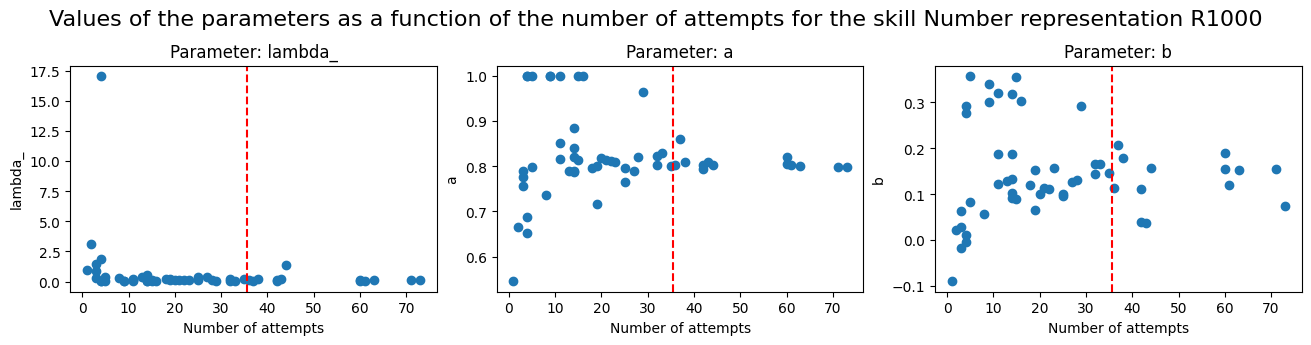

For the skill Multiplication/Division R20 there is 8 students with more than 7 attempts which corresponds to 26.67 % of the students


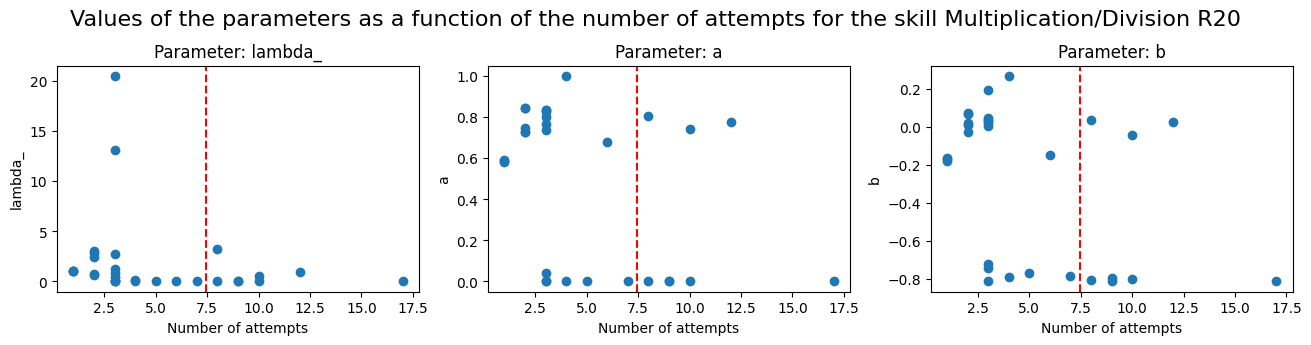

For the skill Number comparison/manipulation R1000 there is 12 students with more than 69 attempts which corresponds to 24.0 % of the students


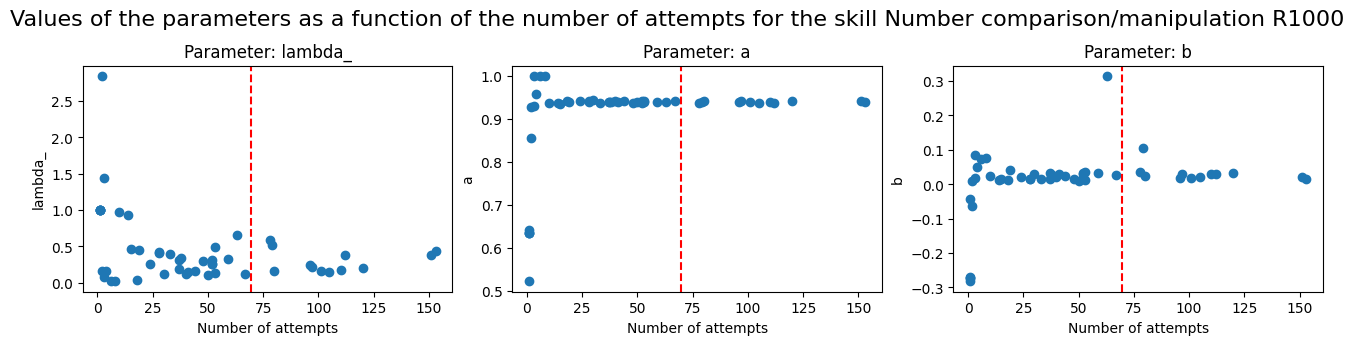

For the skill Addition/Substraction R1000 there is 2 students with more than 7 attempts which corresponds to 8.33 % of the students


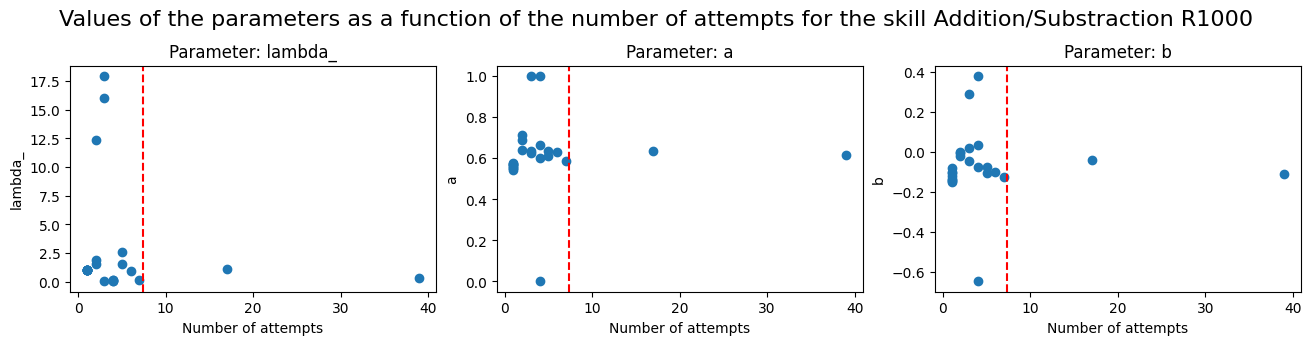

For the skill Multiplication/Division R100 there is 3 students with more than 6 attempts which corresponds to 13.64 % of the students


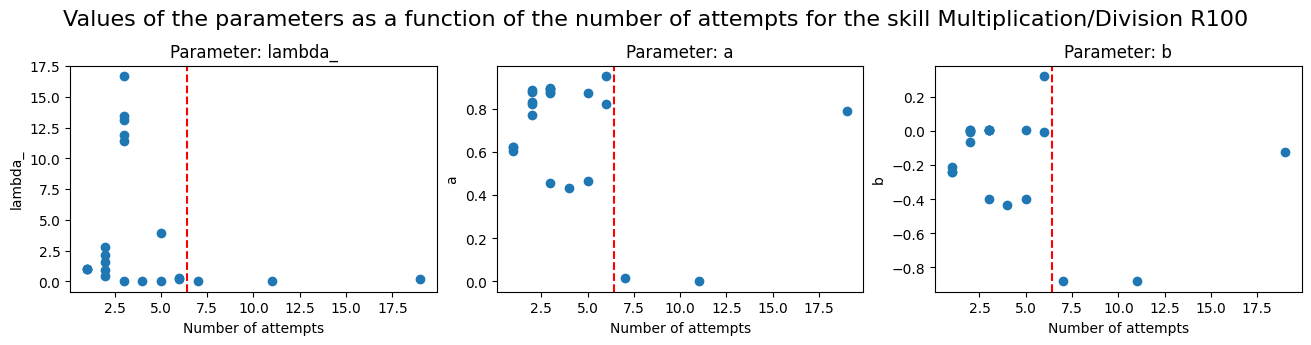

For the skill Addition/Substraction R20 there is 13 students with more than 6 attempts which corresponds to 18.84 % of the students


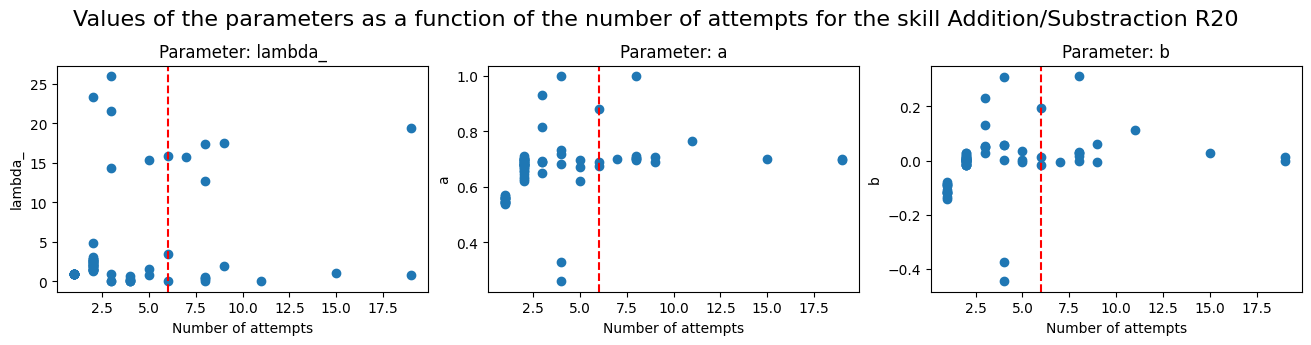

For the skill Multiplication/Division R1000 there is 1 students with more than 7 attempts which corresponds to 9.09 % of the students


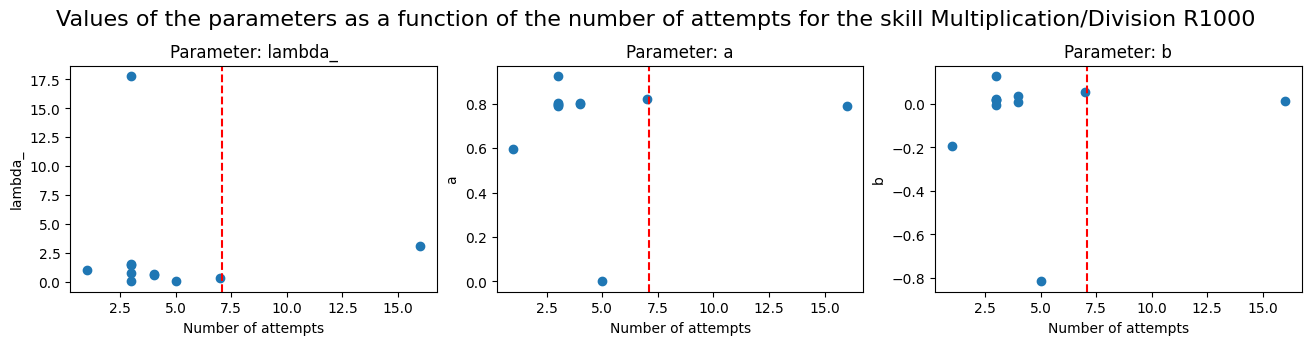

For the skill Multiplication/Division R10 there is 2 students with more than 8 attempts which corresponds to 20.0 % of the students


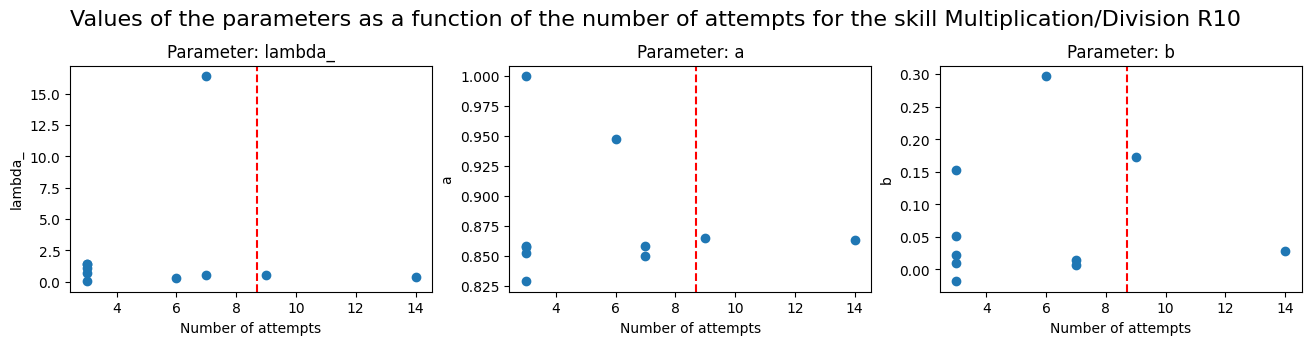

In [84]:
# Plot the values of each parameter as a function of the number of attempts
parameters = ['lambda_', 'a', 'b']
for skill in skills:
    fig, ax = plt.subplots(ncols=3, figsize=(13,3), constrained_layout=True)
    
    # Keep only the students that played the most, i.e. that are more likely to have reached their maximum performance
    min_attempts = scale_param[skill]*1.5
    n_trained_students = students_param[skill][students_param[skill]['number_attempts'] > min_attempts].shape[0]
    print('For the skill', skill, 'there is', n_trained_students, 'students with more than', int(min_attempts), 'attempts which corresponds to', round(n_trained_students/students_param[skill].shape[0]*100, 2), '% of the students')  
    
    for i in range(len(parameters)):
        ax[i].plot(students_param[skill]['number_attempts'], students_param[skill][parameters[i]], 'o')
        ax[i].set_xlabel('Number of attempts')
        ax[i].set_ylabel(parameters[i])
        ax[i].set_title('Parameter: ' + parameters[i])
        ax[i].axvline(x=min_attempts, color='r', linestyle='--', label='Only students with more than ' + str(int(min_attempts)) + ' attempts are kept')
    plt.suptitle('Values of the parameters as a function of the number of attempts for the skill ' + skill, y=1.1, fontsize=16)
    plt.show()

In [87]:
# Extract the median value of each parameter for each skill
median_param = {}
for skill in skills:
    median_param[skill] = students_param[skill][parameters].median()
    
print('The median values of the parameters are:')
median_param = pd.DataFrame(median_param)
display(median_param)

The median values of the parameters are:


,Number representation R10,Number comparison/manipulation R20,Number representation R20,Number comparison/manipulation R10,Addition/Substraction R10,Number representation R100,Number comparison/manipulation R100,Addition/Substraction R100,Number representation R1000,Multiplication/Division R20,Number comparison/manipulation R1000,Addition/Substraction R1000,Multiplication/Division R100,Addition/Substraction R20,Multiplication/Division R1000,Multiplication/Division R10
lambda_,1.000000,0.673648,0.690044,1.100403,1.000000,0.179476,0.523045,1.000000,0.152717,0.590255,0.302033,1.000000,1.000000,1.604199,0.717545,0.614701
a,0.629894,0.901478,0.756941,0.747321,0.719209,0.753819,0.911591,0.618941,0.803690,0.700986,0.939531,0.613834,0.821647,0.684831,0.796147,0.858264
b,0.045484,0.041993,0.076237,0.099910,0.003900,0.151320,0.056096,-0.079111,0.128320,-0.095312,0.021764,-0.091142,-0.006267,0.003078,0.018627,0.025871


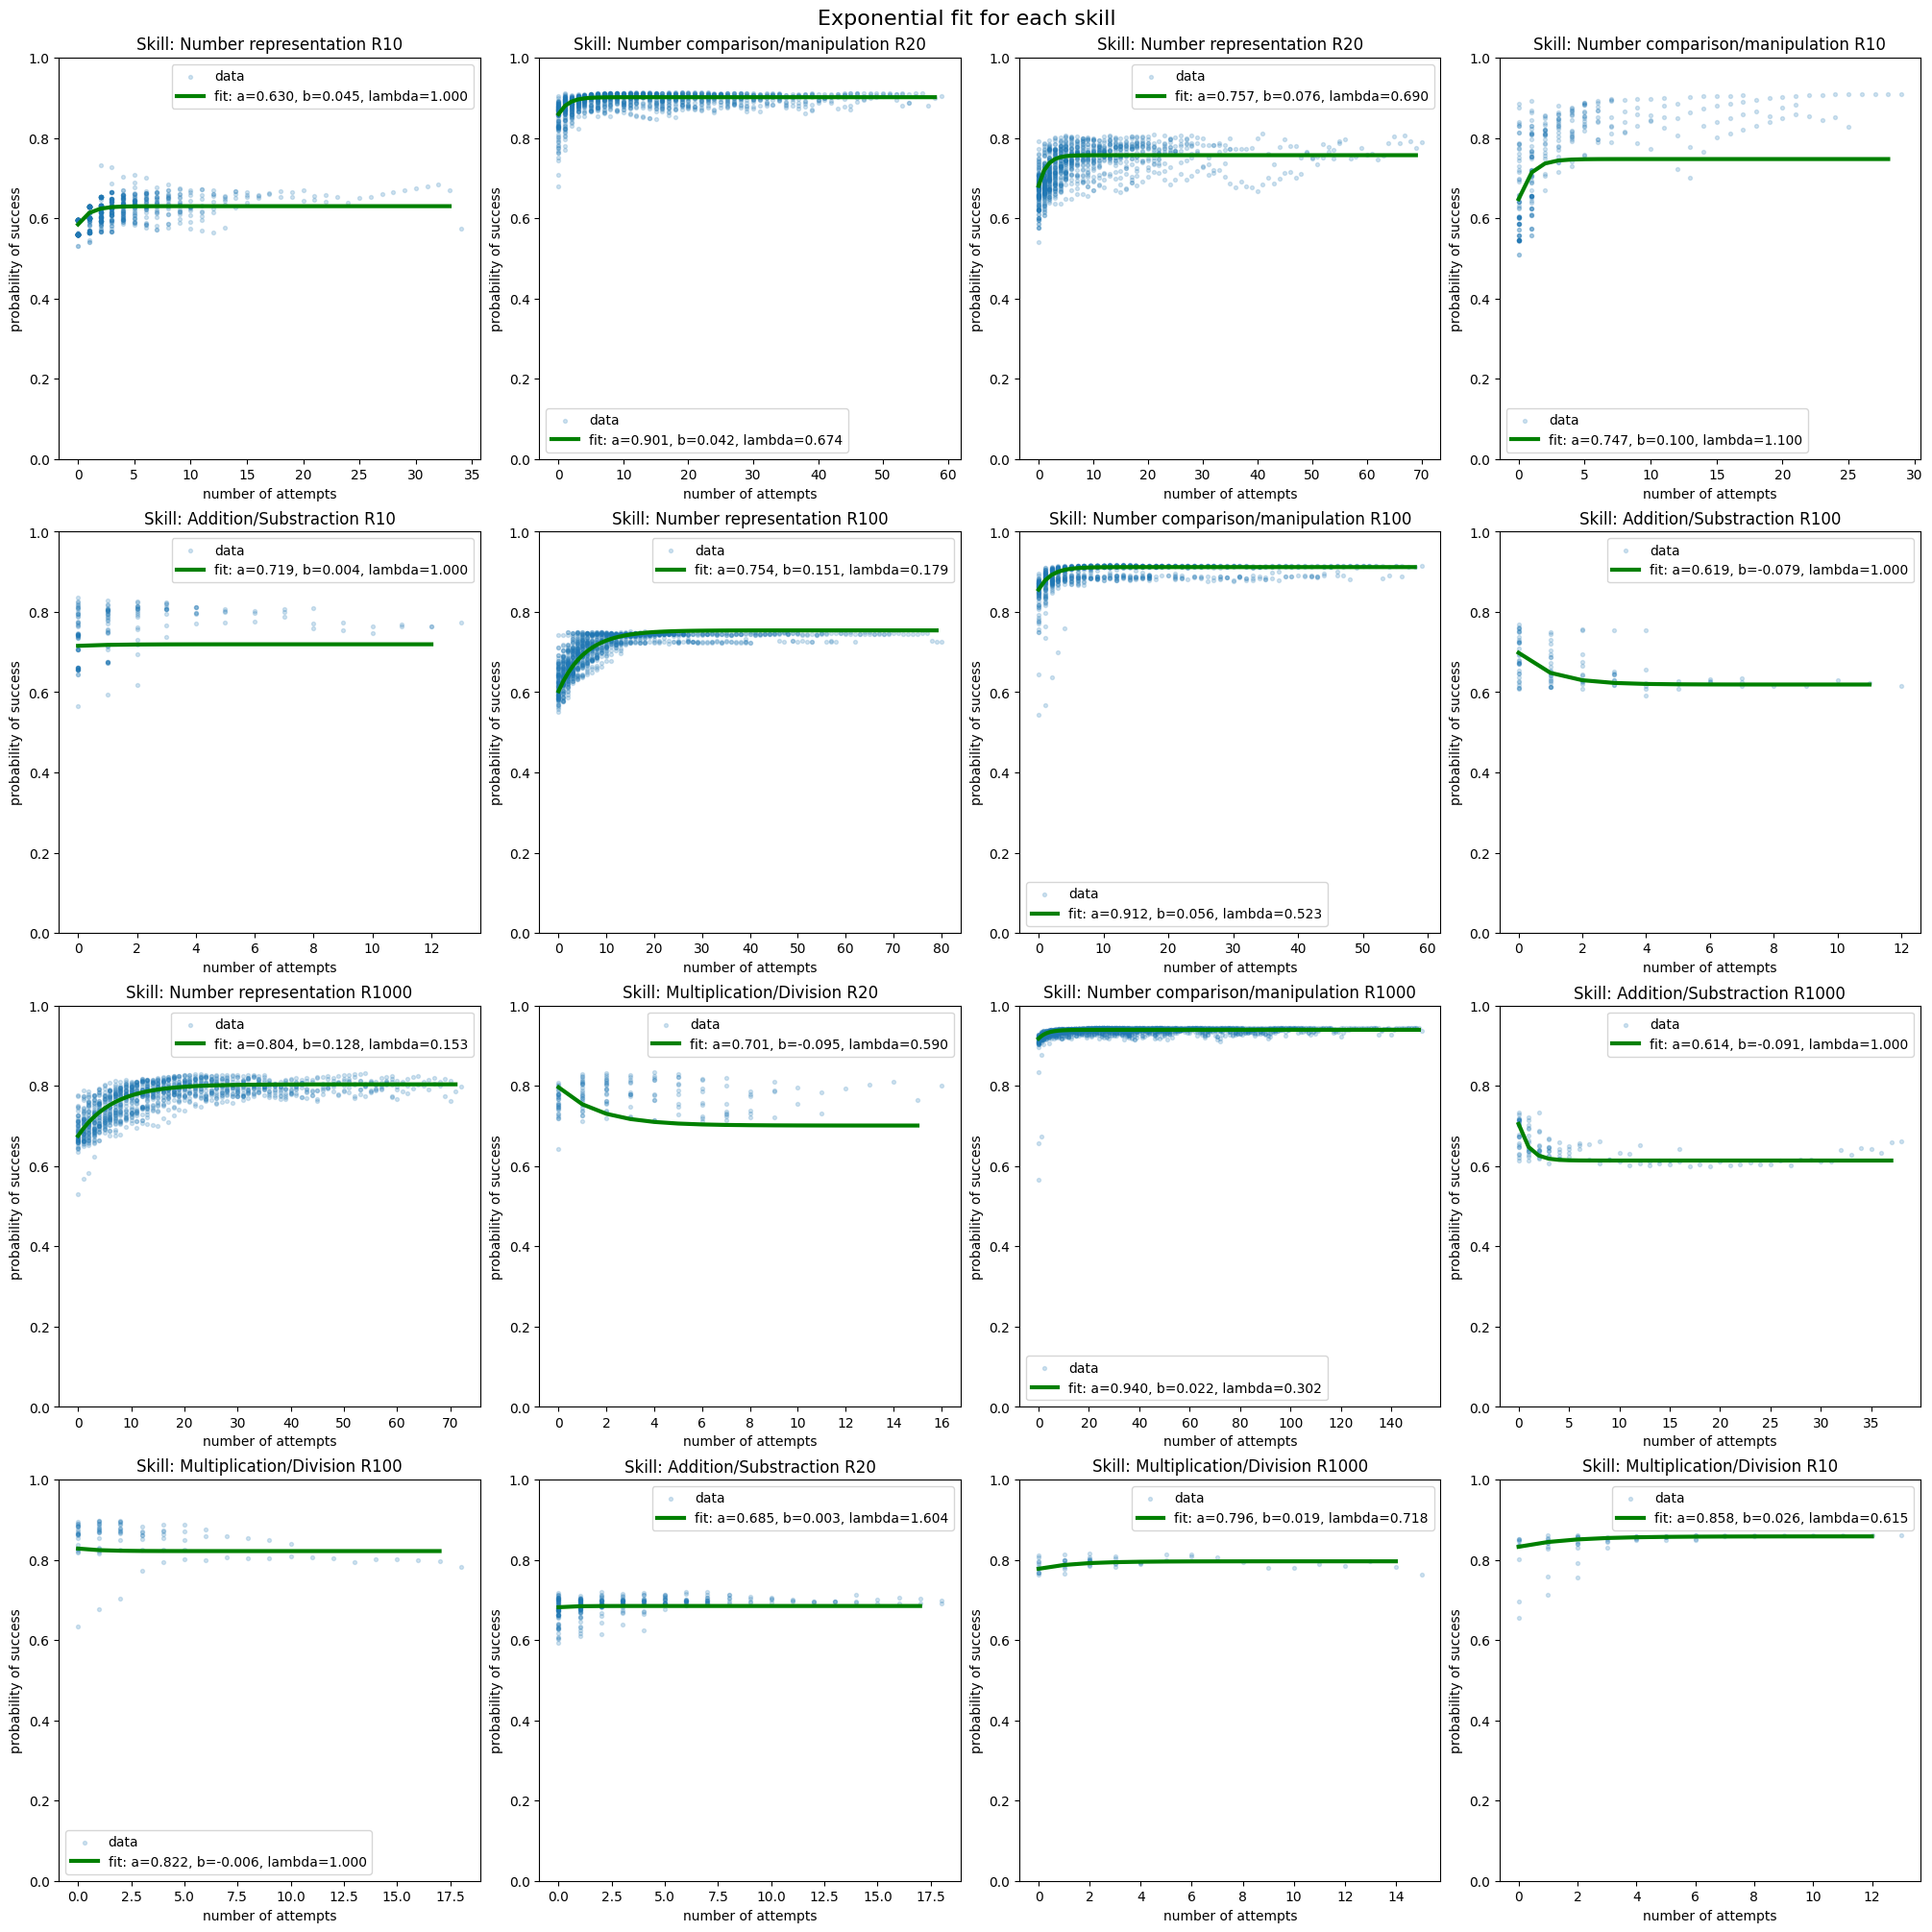

In [88]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20), constrained_layout=True)
for skill, axe in zip(skills, ax.flatten()):
    rx = np.arange(max(proba_dataset[skill].attempt))
    a_pred, b_pred, lambda_pred = median_param[skill].a, median_param[skill].b, median_param[skill].lambda_
    
    axe.scatter(proba_dataset[skill].attempt, proba_dataset[skill].correct_predictions, label='data', alpha=0.2, s=8)
    axe.plot(rx, exp_model(rx, a_pred, b_pred, lambda_pred), label='fit: a=%5.3f, b=%5.3f, lambda=%5.3f' % tuple([a_pred, b_pred, lambda_pred]), color='green', linewidth=3)
    axe.set_xlabel('number of attempts')
    axe.set_ylabel('probability of success')
    axe.set_title('Skill: {}'.format(skill))
    axe.set_ylim(0, 1)
    axe.legend()
plt.suptitle('Exponential fit for each skill', fontsize=16)
plt.show()

# Selection of the relevant skills
Certain skills present a decreasing fit of the exponential function, however we can only predict the number of remaining attempt if the students are indeed learning over training sessions. We will therefore only consider skills with a positive slope (i.e. with the parameter $b > 0$).
Moreover, there are some skills that were trained only by a few students or for a few number of attempts, which makes the exponential fit unreliable. We will therefore only consider skills that were trained for at least X attempts by at least Y students.

In [90]:
removed_skills = subtasks['skill_name'].unique()
# Remove the skills with a negative b parameter
skills = [skill for skill in subtasks['skill_name'].unique() if median_param[skill].b > 0]

# Remove the skills with not enough data
min_attempts = 5
min_students = 25
skills = [skill for skill in skills if 
          students_param[skill][students_param[skill]['number_attempts'] 
                                > min_attempts].shape[0] 
          > min_students]
removed_skills = [skill for skill in removed_skills if skill not in skills]
print('The skills that are removed are:', *removed_skills, sep=', ')

The skills that are removed are:, Number comparison/manipulation R10, Addition/Substraction R10, Addition/Substraction R100, Multiplication/Division R20, Addition/Substraction R1000, Multiplication/Division R100, Addition/Substraction R20, Multiplication/Division R1000, Multiplication/Division R10


# Predict the number of attempts

In [91]:
# Define which probability of success is considered as mastered
print('We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success')
print('Here we display the probability of success considered as mastered for each skill, as well as the expected number of attempts to reach this probability of success, for a student that has not begun to learn the skill yet : ')
mastering = {'proba': {}, 'tot_attempt': {}}
for skill in skills:
    a_pred, b_pred, lambda_pred = median_param[skill].a, median_param[skill].b, median_param[skill].lambda_
    mastering['proba'][skill] = 0.99*a_pred
    mastering['tot_attempt'][skill] = np.ceil((-1/lambda_pred)*np.log((a_pred - mastering['proba'][skill])/b_pred)).astype(int)
display(pd.DataFrame(mastering))

We consider that a student has mastered the skill if the probability of success is higher than 95.5% of the maximum probability of success
Here we display the probability of success considered as mastered for each skill, as well as the expected number of attempts to reach this probability of success, for a student that has not begun to learn the skill yet : 


,proba,tot_attempt
Number representation R10,0.623595,2
Number comparison/manipulation R20,0.892463,3
Number representation R20,0.749371,4
Number representation R100,0.746281,17
Number comparison/manipulation R100,0.902475,4
Number representation R1000,0.795653,19
Number comparison/manipulation R1000,0.930135,3


In [92]:
def attempt_from_proba(proba, a_pred, b_pred, lambda_pred, confidence = 0.99):
    proba_mastering = confidence*a_pred
    if proba > proba_mastering:
        return 0
    else:
        tot_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba_mastering)/b_pred)).astype(int)
        equivalent_attempt = np.ceil((-1/lambda_pred)*np.log((a_pred - proba)/b_pred)).astype(int)
        return tot_attempt - equivalent_attempt

To test our model and predict the number of attempts needed to master a skill, we will use the data of the test set. <br>
To do so, we (theoretically) only need the probability prediction for the last attempt (which summarise all the data we have for a student until now). <br>
However, as we want to compare our predictions with the real number of attempts, we will use a previous attempt as 'fake' last attempt and predict the number of attempts needed to master the skill from this fake last attempt.

In [93]:
test_dataset = {}
for skill in skills:    
    # Extract the correct prediction for the 3rd attempt for each student (if it exists)
    third_proba = proba_test[skill][proba_test[skill]['attempt'] == 3].rename(columns={'correct_predictions': 'third_proba'}).drop(columns=['attempt'])

    # Extract the first attempt number from which the student has actually mastered the skill (this is done by computing a moving average on the correct predictions beforehand)
    mastering_attempt = proba_test[skill].groupby('user_id').rolling(1, on='attempt', min_periods=1)['correct_predictions'].mean().reset_index()
    mastering_attempt = (mastering_attempt[mastering_attempt['correct_predictions'] >= mastering['proba'][skill]]).groupby('user_id')['attempt'].first().rename('true_attempts')
    
    # Merge de 2 dataframes and keep only the students that have both a 3rd attempt and a mastered the skill
    test_dataset[skill] = pd.merge(third_proba, mastering_attempt, on='user_id', how='inner')
    
test_dataset['Number representation R100']

,user_id,skill_name,third_proba,true_attempts
0,33,Number representation R100,0.680791,9
1,36,Number representation R100,0.726954,4
2,68,Number representation R100,0.708442,15
3,84,Number representation R100,0.627339,4
4,103,Number representation R100,0.694334,20
5,109,Number representation R100,0.640954,6
6,153,Number representation R100,0.674539,7
7,156,Number representation R100,0.642826,8
8,193,Number representation R100,0.650868,17
9,207,Number representation R100,0.655640,8


In [94]:
# Predict the number of attempts needed to master the skill
for skill in skills:
    a_pred, b_pred, lambda_pred = median_param[skill].a, median_param[skill].b, median_param[skill].lambda_
    test_dataset[skill]['predicted_attempts'] = test_dataset[skill].third_proba.apply(lambda x: attempt_from_proba(x, a_pred, b_pred, lambda_pred))
print(mastering['proba']['Number representation R100'])
test_dataset['Number representation R100']


0.746280677337239


,user_id,skill_name,third_proba,true_attempts,predicted_attempts
0,33,Number representation R100,0.680791,9,12
1,36,Number representation R100,0.726954,4,7
2,68,Number representation R100,0.708442,15,10
3,84,Number representation R100,0.627339,4,16
4,103,Number representation R100,0.694334,20,11
5,109,Number representation R100,0.640954,6,15
6,153,Number representation R100,0.674539,7,13
7,156,Number representation R100,0.642826,8,15
8,193,Number representation R100,0.650868,17,14
9,207,Number representation R100,0.655640,8,14


# Evaluate the model

In [95]:
describe_df = pd.DataFrame()
for skill in skills:
    describe_df[skill + ' true'] = test_dataset[skill].true_attempts.describe()
    describe_df[skill + ' predicted'] = test_dataset[skill].predicted_attempts.describe()
display(describe_df)


,Number representation R10 true,Number representation R10 predicted,Number comparison/manipulation R20 true,Number comparison/manipulation R20 predicted,Number representation R20 true,Number representation R20 predicted,Number representation R100 true,Number representation R100 predicted,Number comparison/manipulation R100 true,Number comparison/manipulation R100 predicted,Number representation R1000 true,Number representation R1000 predicted,Number comparison/manipulation R1000 true,Number comparison/manipulation R1000 predicted
count,71.000000,71.000000,67.000000,67.000000,62.000000,62.000000,38.000000,38.000000,56.000000,56.000000,33.000000,33.000000,40.000000,40.000000
mean,2.323944,0.267606,2.791045,0.492537,5.258065,1.677419,11.631579,11.315789,3.446429,1.000000,14.090909,14.848485,3.650000,0.600000
std,1.969588,0.559534,1.813563,0.766201,6.815930,1.479634,9.059625,4.337799,1.838177,1.361817,7.177933,3.518888,1.981323,0.900142
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,5.000000,8.000000,1.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,6.000000,10.000000,2.000000,0.000000,9.000000,12.000000,2.000000,0.000000
50%,2.000000,0.000000,3.000000,0.000000,4.000000,2.000000,8.500000,13.000000,3.000000,0.000000,11.000000,16.000000,3.000000,0.000000
75%,3.000000,0.000000,4.000000,1.000000,6.000000,3.000000,15.750000,14.000000,4.000000,2.000000,17.000000,18.000000,5.000000,1.000000
max,11.000000,2.000000,8.000000,3.000000,49.000000,4.000000,47.000000,16.000000,9.000000,6.000000,40.000000,19.000000,8.000000,3.000000


,Number representation R10,Number comparison/manipulation R20,Number representation R20,Number representation R100,Number comparison/manipulation R100,Number representation R1000,Number comparison/manipulation R1000
MAE,2.056338,2.328358,3.709677,6.315789,2.553571,4.212121,3.05


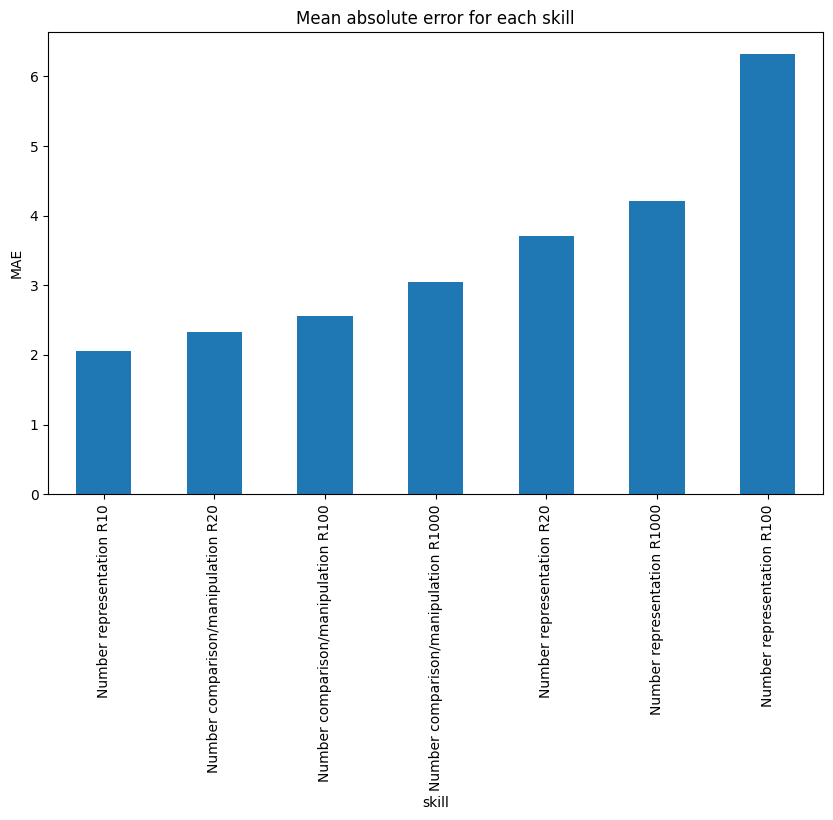

In [96]:
# Compute the RMSE
mae = {}
for skill in skills:
    mae[skill] = np.mean(np.abs(test_dataset[skill].true_attempts - test_dataset[skill].predicted_attempts))
mae = pd.DataFrame(mae, index=['MAE'])
display(mae)

# Sort the skills by MAE
mae = mae.transpose().sort_values(by='MAE')
mae.plot.bar(figsize=(10, 6), title='Mean absolute error for each skill', legend=False, xlabel='skill', ylabel='MAE')

plt.show()

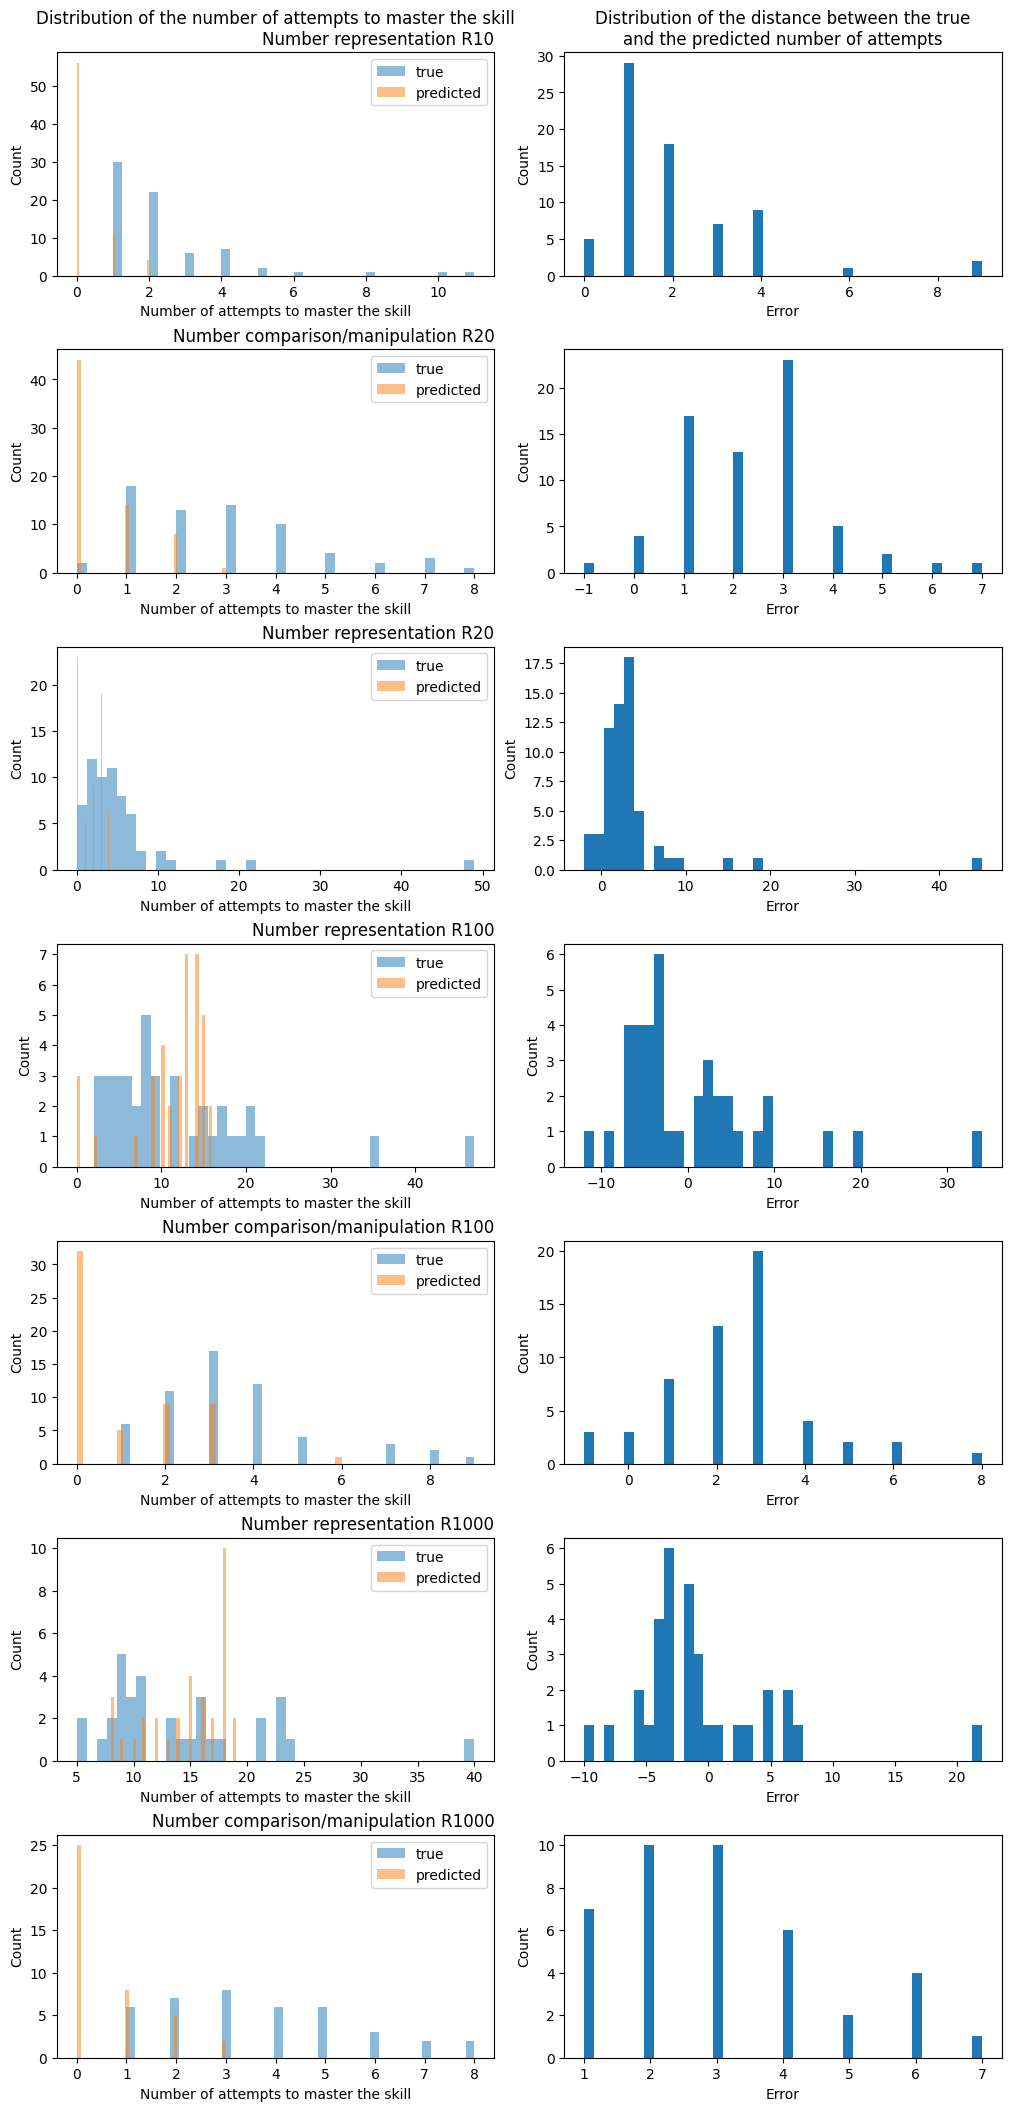

In [97]:
fig, ax = plt.subplots(len(skills), 2, figsize=(10, len(skills)*3), constrained_layout=True)
ax[0][0].set_title('Distribution of the number of attempts to master the skill\n')
ax[0][1].set_title('Distribution of the distance between the true\nand the predicted number of attempts')
# Plot both distributions
for skill in skills:
    ax[skills.index(skill)][0].hist(test_dataset[skill].true_attempts, bins=40, alpha=0.5, label='true')
    ax[skills.index(skill)][0].hist(test_dataset[skill].predicted_attempts, bins=40, alpha=0.5, label='predicted')
    ax[skills.index(skill)][0].set_xlabel('Number of attempts to master the skill')
    ax[skills.index(skill)][0].set_ylabel('Count')
    ax[skills.index(skill)][0].set_title(skill, loc='right')
    ax[skills.index(skill)][0].legend()

    # Plot the distribution of the error
    ax[skills.index(skill)][1].hist(test_dataset[skill].true_attempts - test_dataset[skill].predicted_attempts, bins=40)
    ax[skills.index(skill)][1].set_xlabel('Error')
    ax[skills.index(skill)][1].set_ylabel('Count')
plt.show()